# Fundamental Value Strategies
*Note: [Read our Medium Article on Fundamental Value Strategies](https://medium.com/protos-fund/top-4-ratios-to-make-sense-of-cryptoassets-94628faad60a)*

## Transaction Volume & Trading Volume

NVT: Network Value to Transaction Volume (MarketCap / Transaction Volume) <br>
NVV: Network Value to Trading Volume (MarketCap / Trading Volume)

In [12]:
import new_protos_edge as npe
import pandas as pd
import numpy as np
import ipywidgets as widgets

### Set Up the Strategy Backtests:

Which type of *Fundamental Ratio* do you want to test?

**NVT**: Network Value to Trasnaction Volume<br>
**NVV**: Network Value to Trading Volume 

In [13]:
widget_fundamental = widgets.ToggleButtons(
    options={'NVT':'nvt','NVV':'nvv'},
    description='Ratios:',
    disabled=False,
    button_style='', # 'success', 'info', 'warning', 'danger' or ''
    tooltips=['Network Value to Transaction Volume', 'Network Value to Trading Volume'],
)

widget_nr_tickers = widgets.IntSlider(
    value=6,
    min=0,
    max=10,
    step=1,
    description='Tickers:',
    disabled=False,
    continuous_update=False,
    orientation='horizontal',
    readout=True,
    readout_format='d'
)

widget_select_tickers = widgets.SelectMultiple(
    options=['bitcoin','ethereum','ripple','litecoin','dash','nem', 'ethereum-classic',
               'zcash','pivx','golem-network-tokens','decred','digibyte','dogecoin',
               'verge'],
    value=['bitcoin'],
    #rows=10,
    description='Tickers',
    disabled=False
)

widget_strategy = widgets.ToggleButtons(
    options={'Buy Largest':'largest','Buy Smallest':'smallest','Buy Large, Sell Small':'largest-smallest',
            'Buy Small, Sell Large':'smallest-largest'},
    disabled=False,
    button_style='', # 'success', 'info', 'warning', 'danger' or ''
    tooltips=['Buy the largest x currencies', 'Buy the smallest x currencies',
             'Buy the largest x currencies, Sell the smallest x currencies',
             'Buy the smallest x currencies, Sell the largest x currencies'],
)

widget_rebalancing_period = widgets.IntSlider(
    value=4,
    min=1,
    max=90,
    step=1,
    description='Rebalancing:',
    disabled=False,
    continuous_update=False,
    orientation='horizontal',
    readout=True,
    readout_format='d'
)

widget_spread = widgets.FloatSlider(
    value=0.006,
    min=0,
    max=0.02,
    step=0.001,
    description='Spread:',
    disabled=False,
    continuous_update=False,
    orientation='horizontal',
    readout=True,
    readout_format='.3f',
)

In [14]:
display(widget_fundamental)

ToggleButtons(description='Ratios:', options={'NVT': 'nvt', 'NVV': 'nvv'}, tooltips=['Network Value to Transaction Volume', 'Network Value to Trading Volume'], value='nvt')

### Strategy Parameters
#### Choose your strategy:
***Long-Only*** or ***Long-Short?***<br>
Buying the tickers with the ***largest*** or with the ***smallest*** Ratios?<br>
*Note: When choosing a Long-Short Strategy you the buy the largest/smallest x tickers and sell the opposite x tickers*

In [15]:
display(widget_nr_tickers)
display(widget_strategy)

IntSlider(value=6, continuous_update=False, description='Tickers:', max=10)

ToggleButtons(options={'Buy Largest': 'largest', 'Buy Smallest': 'smallest', 'Buy Large, Sell Small': 'largest-smallest', 'Buy Small, Sell Large': 'smallest-largest'}, tooltips=['Buy the largest x currencies', 'Buy the smallest x currencies', 'Buy the largest x currencies, Sell the smallest x currencies', 'Buy the smallest x currencies, Sell the largest x currencies'], value='largest')

### Backtest Parameters
Rebalancing: Rebalance the portfolio every x days <br>
Spread: When buying selling the actual buy/sell price is above or below the market price<br>
*Note: The Spread gets subtracted from the Portfolio Balance as transaction costs*

In [16]:
display(widget_rebalancing_period)

IntSlider(value=4, continuous_update=False, description='Rebalancing:', max=90, min=1)

### Load Data

In [21]:
# Collect Parameters
fundamental = widget_fundamental.value
strategy = widget_strategy.value
nr_tickers = widget_nr_tickers.value
param = [strategy, nr_tickers]
rebalancing_period = widget_rebalancing_period.value
spread = widget_spread.value
lb = 1

In [22]:
if(fundamental == "nvv"): 
    vol, prices, mcap = npe.loadData('nvv')
if(fundamental == "nvt"): 
    vol, prices, mcap = npe.loadData('nvt')
nvx = mcap/vol

### Start Backtest

In [23]:
track_balance = []
portfolio = npe.initPortfolio(prices.iloc[:1], vol.iloc[:1], param,"nvx")

for i in range(lb,prices.shape[0]):
    
    if(i > lb):
        portfolio = npe.updateBalance(portfolio,prices.iloc[:i,:])
    
    signals = npe.getSignals("nvx",prices.iloc[:i,:],nvx.iloc[:i,:],param)
    
    targetAlloc = npe.RiskManagement(signals,portfolio,prices.iloc[:i,:])
    
    if(i%rebalancing_period == 0):
        portfolio = npe.updatePositions(portfolio,targetAlloc,prices.iloc[:i,:], spread)
    
    track_balance.append(portfolio['balance'])

### Results and Statistics

Balance: 49489.65291588582
--------------------------------------
bitcoin                     0.000000
dash                        0.000000
decred                      0.000000
digibyte                    0.000000
dogecoin                    0.000000
ethereum                    0.000000
ethereum-classic            0.000000
golem-network-tokens        0.000000
litecoin                    0.000000
nem                         0.000000
pivx                        0.000000
ripple                  40830.259840
verge                       0.000000
zcash                      87.158333
Name: 2018-05-25 00:00:00, dtype: float64
--------------------------------------
Sharpe: [3.20714677]
--------------------------------------
Gain-to-Pain : [0.73599371]


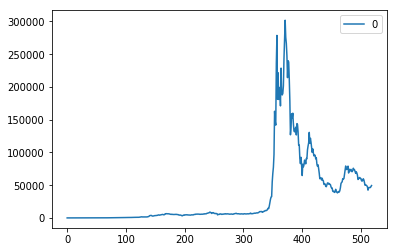

In [24]:
balance = pd.DataFrame(track_balance)
balance.plot()
returns = balance.pct_change()


print("Balance: " + str(portfolio['balance']))
print("--------------------------------------")
print(portfolio['positions'])
print("--------------------------------------")
print("Sharpe: " + str((returns.mean()/(returns.std())*np.sqrt(365)).values))
print("--------------------------------------")
print("Gain-to-Pain : " + str((returns.sum()/abs(returns[returns < 0].sum())).values))